In [1]:
!pip install git+https://github.com/firekind/athena

  Cloning https://github.com/firekind/athena to /tmp/pip-req-build-unpbpitn
  Running command git clone -q https://github.com/firekind/athena /tmp/pip-req-build-unpbpitn
  Created wheel for athena: filename=athena-1.0.0-cp36-none-any.whl size=50819 sha256=455b3e8459437465ff80ee83f9006b4908e60fab681a6b7d6028e3d8cd863043
  Stored in directory: /tmp/pip-ephem-wheel-cache-ipgvyydy/wheels/36/d3/7b/d9500a9af2498abc5d48d60c7db37c1456ee745049da352e0b
Successfully built athena


In [2]:
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, OneCycleLR, ReduceLROnPlateau

from athena import datasets, Experiment, Experiments, ClassificationSolver
from athena.visualizations import plot_experiments, plot_misclassified
from athena.utils.transforms import ToNumpy, ToTensor
from athena.models import ResNet18, DavidNet
from athena.tuning import lr_finder

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 512
epochs = 24

cuda


In [4]:
net = DavidNet().to(device)

summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
       LayerBlock-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [5]:
import cv2

train_loader = (
    datasets.cifar10()
    .batch_size(batch_size)
    .train()
    .transform(A.Compose([
        A.Lambda(ToNumpy),
        A.PadIfNeeded(36, 36, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.RandomCrop(32, 32),
        A.HorizontalFlip(p=0.5),
        A.Cutout(num_holes=1, max_h_size=8, max_w_size=8),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
        A.Lambda(ToTensor)
    ]))
    .build()
)

test_loader = (
    datasets.cifar10()
    .batch_size(batch_size)
    .test()
    .transform(A.Compose([
        A.Lambda(ToNumpy),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
        A.Lambda(ToTensor)
    ]))
    .build()
)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified








































Learning rate search finished. See the graph with {finder_name}.plot()


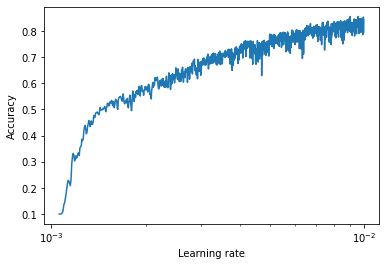

In [6]:
from athena.tuning import lr_finder

def acc_fn(outputs, labels):
    pred = outputs.argmax(dim=1, keepdim=True)
    correct = pred.eq(labels.view_as(pred)).float()
    return correct.mean()


optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
criterion = F.cross_entropy

lr_finder = lr_finder.LRFinder(net, optimizer, criterion, acc_fn = acc_fn, device=device)

# Starting range test
lr_finder.reset()
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=1e-2, num_iter=1500, step_mode="linear")
res = lr_finder.plot(mode="acc")

LR suggestion: steepest gradient
Suggested LR: 1.28E-03


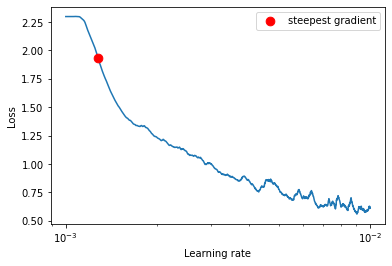

In [7]:
res = lr_finder.plot(skip_start=0, skip_end=0)

In [9]:
# creating the experiment
exp = (
    Experiment.builder()
    .name("Super Convergence with OneCycle")
    .log_directory("log_dir")
    # .add("OneCycle - 1.28e-3")
      .model(ResNet18())
      .solver(ClassificationSolver)
          .optimizer(optim.SGD, lr=1.28E-03, momentum=0.9)
          .scheduler(optim.lr_scheduler.OneCycleLR, max_lr=1.28E-03, div_factor=8, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=5/epochs, anneal_strategy="linear")
          .epochs(epochs)
          .train_loader(train_loader)
          .test_loader(test_loader)
          .loss_fn(criterion)
          .device("cuda")
          .build()
      .build() 
)

# running experiment
exp.run()

=> Running experiment: Super Convergence with OneCycle
Epoch: 1 / 24
98/98 [==============================] - 65s 659ms/step - train loss: 2.1227 - train accuracy: 21.4120
Test set: Average loss: 1.8612, Accuracy: 3257/10000 (32.57%)

Epoch: 2 / 24
98/98 [==============================] - 64s 649ms/step - train loss: 1.7185 - train accuracy: 37.2020
Test set: Average loss: 1.6014, Accuracy: 4143/10000 (41.43%)

Epoch: 3 / 24
98/98 [==============================] - 63s 645ms/step - train loss: 1.5202 - train accuracy: 44.1480
Test set: Average loss: 1.4575, Accuracy: 4638/10000 (46.38%)

Epoch: 4 / 24
98/98 [==============================] - 63s 647ms/step - train loss: 1.3853 - train accuracy: 49.2540
Test set: Average loss: 1.3423, Accuracy: 5111/10000 (51.11%)

Epoch: 5 / 24
98/98 [==============================] - 63s 648ms/step - train loss: 1.2782 - train accuracy: 53.6160
Test set: Average loss: 1.2579, Accuracy: 5429/10000 (54.29%)

Epoch: 6 / 24
98/98 [========================

In [10]:
# creating the experiment
exp2 = (
    Experiment.builder()
    .name("Super Convergence with OneCycle - Max-0.008")
    .log_directory("log_dir")
    # .add("OneCycle - 1.28e-3")
      .model(ResNet18())
      .solver(ClassificationSolver)
          .optimizer(optim.SGD, lr=0.008, momentum=0.9)
          .scheduler(optim.lr_scheduler.OneCycleLR, max_lr=0.008, div_factor=8, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=5/epochs, anneal_strategy="linear")
          .epochs(epochs)
          .train_loader(train_loader)
          .test_loader(test_loader)
          .loss_fn(criterion)
          .device("cuda")
          .build()
      .build() 
)

# running experiment
exp2.run()

=> Running experiment: Super Convergence with OneCycle - Max-0.008
Epoch: 1 / 24
98/98 [==============================] - 65s 661ms/step - train loss: 1.8365 - train accuracy: 31.9580
Test set: Average loss: 1.4648, Accuracy: 4511/10000 (45.11%)

Epoch: 2 / 24
98/98 [==============================] - 63s 647ms/step - train loss: 1.3243 - train accuracy: 51.4340
Test set: Average loss: 1.2297, Accuracy: 5532/10000 (55.32%)

Epoch: 3 / 24
98/98 [==============================] - 63s 644ms/step - train loss: 1.0785 - train accuracy: 60.9920
Test set: Average loss: 0.9992, Accuracy: 6390/10000 (63.90%)

Epoch: 4 / 24
98/98 [==============================] - 64s 650ms/step - train loss: 0.9066 - train accuracy: 67.6040
Test set: Average loss: 0.9641, Accuracy: 6688/10000 (66.88%)

Epoch: 5 / 24
98/98 [==============================] - 63s 648ms/step - train loss: 0.7670 - train accuracy: 72.9140
Test set: Average loss: 0.9207, Accuracy: 6974/10000 (69.74%)

Epoch: 6 / 24
98/98 [============

In [11]:
# creating the experiment
exp3 = (
    Experiment.builder()
    .name("Super Convergence with OneCycle - Max-0.009")
    .log_directory("log_dir")
    # .add("OneCycle - 1.28e-3")
      .model(ResNet18())
      .solver(ClassificationSolver)
          .optimizer(optim.SGD, lr=0.009, momentum=0.9)
          .scheduler(optim.lr_scheduler.OneCycleLR, max_lr=0.009, div_factor=8, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=5/epochs, anneal_strategy="linear")
          .epochs(epochs)
          .train_loader(train_loader)
          .test_loader(test_loader)
          .loss_fn(criterion)
          .device("cuda")
          .build()
      .build() 
)

# running experiment
exp3.run()

=> Running experiment: Super Convergence with OneCycle - Max-0.009
Epoch: 1 / 24
98/98 [==============================] - 65s 659ms/step - train loss: 1.7963 - train accuracy: 32.8960
Test set: Average loss: 1.4823, Accuracy: 4460/10000 (44.60%)

Epoch: 2 / 24
98/98 [==============================] - 63s 644ms/step - train loss: 1.2983 - train accuracy: 52.5720
Test set: Average loss: 1.1856, Accuracy: 5745/10000 (57.45%)

Epoch: 3 / 24
98/98 [==============================] - 63s 643ms/step - train loss: 1.0616 - train accuracy: 62.0300
Test set: Average loss: 1.0158, Accuracy: 6360/10000 (63.60%)

Epoch: 4 / 24
98/98 [==============================] - 63s 647ms/step - train loss: 0.8793 - train accuracy: 68.6820
Test set: Average loss: 0.9776, Accuracy: 6630/10000 (66.30%)

Epoch: 5 / 24
98/98 [==============================] - 64s 649ms/step - train loss: 0.7481 - train accuracy: 73.6280
Test set: Average loss: 1.2492, Accuracy: 6325/10000 (63.25%)

Epoch: 6 / 24
98/98 [============

In [12]:
# creating the experiment
exp4 = (
    Experiment.builder()
    .name("Super Convergence with OneCycle - Max-0.007")
    .log_directory("log_dir")
    # .add("OneCycle - 1.28e-3")
      .model(ResNet18())
      .solver(ClassificationSolver)
          .optimizer(optim.SGD, lr=0.007, momentum=0.9)
          .scheduler(optim.lr_scheduler.OneCycleLR, max_lr=0.007, div_factor=8, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=5/epochs, anneal_strategy="linear")
          .epochs(epochs)
          .train_loader(train_loader)
          .test_loader(test_loader)
          .loss_fn(criterion)
          .device("cuda")
          .build()
      .build() 
)

# running experiment
exp4.run()

=> Running experiment: Super Convergence with OneCycle - Max-0.007
Epoch: 1 / 24
98/98 [==============================] - 65s 659ms/step - train loss: 1.8621 - train accuracy: 31.2020
Test set: Average loss: 1.5189, Accuracy: 4315/10000 (43.15%)

Epoch: 2 / 24
98/98 [==============================] - 63s 645ms/step - train loss: 1.3558 - train accuracy: 50.6520
Test set: Average loss: 1.3113, Accuracy: 5240/10000 (52.40%)

Epoch: 3 / 24
98/98 [==============================] - 63s 644ms/step - train loss: 1.1326 - train accuracy: 59.1660
Test set: Average loss: 1.0260, Accuracy: 6315/10000 (63.15%)

Epoch: 4 / 24
98/98 [==============================] - 64s 650ms/step - train loss: 0.9403 - train accuracy: 66.4820
Test set: Average loss: 1.0012, Accuracy: 6516/10000 (65.16%)

Epoch: 5 / 24
98/98 [==============================] - 63s 645ms/step - train loss: 0.8144 - train accuracy: 71.0840
Test set: Average loss: 0.7858, Accuracy: 7185/10000 (71.85%)

Epoch: 6 / 24
98/98 [============

In [14]:
# creating the experiment
exp5 = (
    Experiment.builder()
    .name("Super Convergence with OneCycle - Max-0.0097")
    .log_directory("log_dir")
    # .add("OneCycle - 1.28e-3")
      .model(ResNet18())
      .solver(ClassificationSolver)
          .optimizer(optim.SGD, lr=0.0097, momentum=0.9)
          .scheduler(optim.lr_scheduler.OneCycleLR, max_lr=0.0097, div_factor=8, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=5/epochs, anneal_strategy="linear")
          .epochs(epochs)
          .train_loader(train_loader)
          .test_loader(test_loader)
          .loss_fn(criterion)
          .device("cuda")
          .build()
      .build() 
)

# running experiment
exp5.run()

=> Running experiment: Super Convergence with OneCycle - Max-0.0097
Epoch: 1 / 24
98/98 [==============================] - 65s 658ms/step - train loss: 1.7787 - train accuracy: 33.7460
Test set: Average loss: 1.6915, Accuracy: 3991/10000 (39.91%)

Epoch: 2 / 24
98/98 [==============================] - 63s 645ms/step - train loss: 1.2823 - train accuracy: 53.3260
Test set: Average loss: 1.2351, Accuracy: 5485/10000 (54.85%)

Epoch: 3 / 24
98/98 [==============================] - 63s 643ms/step - train loss: 1.0428 - train accuracy: 62.5240
Test set: Average loss: 1.0981, Accuracy: 6026/10000 (60.26%)

Epoch: 4 / 24
98/98 [==============================] - 64s 649ms/step - train loss: 0.8798 - train accuracy: 68.6640
Test set: Average loss: 0.8757, Accuracy: 6942/10000 (69.42%)

Epoch: 5 / 24
98/98 [==============================] - 64s 648ms/step - train loss: 0.7550 - train accuracy: 73.2360
Test set: Average loss: 1.0122, Accuracy: 6655/10000 (66.55%)

Epoch: 6 / 24
98/98 [===========

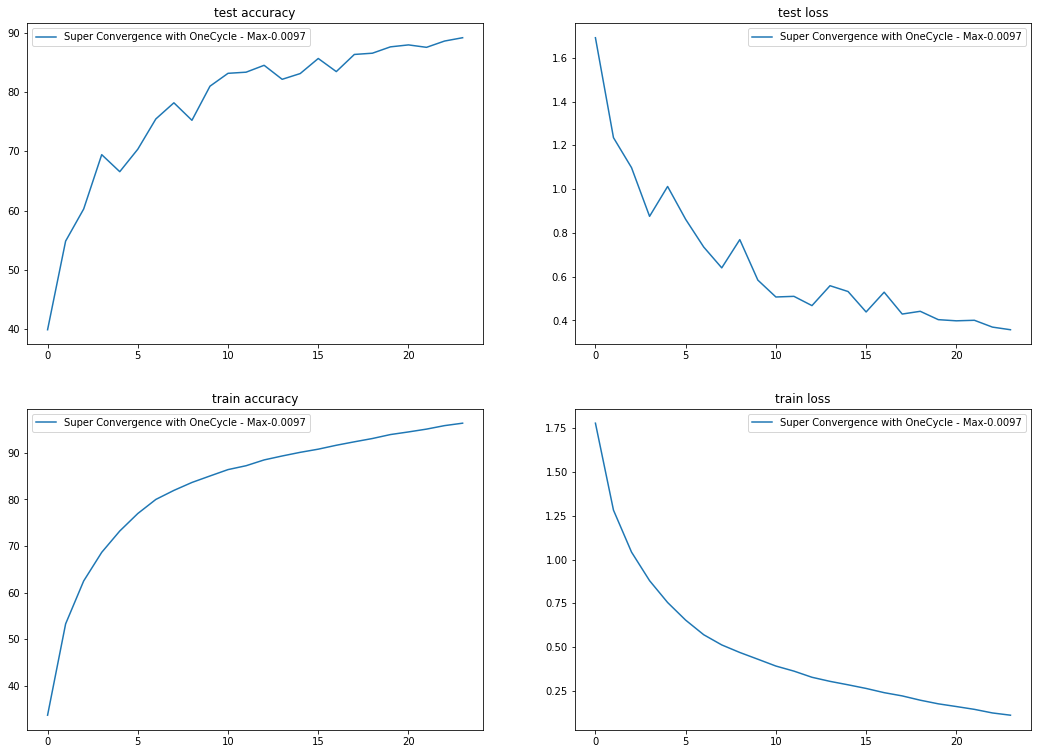

In [15]:
plot_experiments([exp5])

In [16]:
# creating the experiment
exp6 = (
    Experiment.builder()
    .name("Super Convergence with OneCycle - Max-0.01")
    .log_directory("log_dir")
    # .add("OneCycle - 1.28e-3")
      .model(ResNet18())
      .solver(ClassificationSolver)
          .optimizer(optim.SGD, lr=0.01, momentum=0.9)
          .scheduler(optim.lr_scheduler.OneCycleLR, max_lr=0.01, div_factor=8, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=5/epochs, anneal_strategy="linear")
          .epochs(epochs)
          .train_loader(train_loader)
          .test_loader(test_loader)
          .loss_fn(criterion)
          .device("cuda")
          .build()
      .build() 
)

# running experiment
exp6.run()

=> Running experiment: Super Convergence with OneCycle - Max-0.01
Epoch: 1 / 24
98/98 [==============================] - 65s 660ms/step - train loss: 1.7969 - train accuracy: 32.7140
Test set: Average loss: 1.4763, Accuracy: 4555/10000 (45.55%)

Epoch: 2 / 24
98/98 [==============================] - 64s 649ms/step - train loss: 1.2945 - train accuracy: 52.6840
Test set: Average loss: 1.2150, Accuracy: 5649/10000 (56.49%)

Epoch: 3 / 24
98/98 [==============================] - 63s 645ms/step - train loss: 1.0416 - train accuracy: 62.5360
Test set: Average loss: 0.9740, Accuracy: 6475/10000 (64.75%)

Epoch: 4 / 24
98/98 [==============================] - 64s 652ms/step - train loss: 0.8549 - train accuracy: 69.4840
Test set: Average loss: 1.0160, Accuracy: 6374/10000 (63.74%)

Epoch: 5 / 24
98/98 [==============================] - 64s 649ms/step - train loss: 0.7298 - train accuracy: 74.5040
Test set: Average loss: 0.7964, Accuracy: 7236/10000 (72.36%)

Epoch: 6 / 24
98/98 [=============

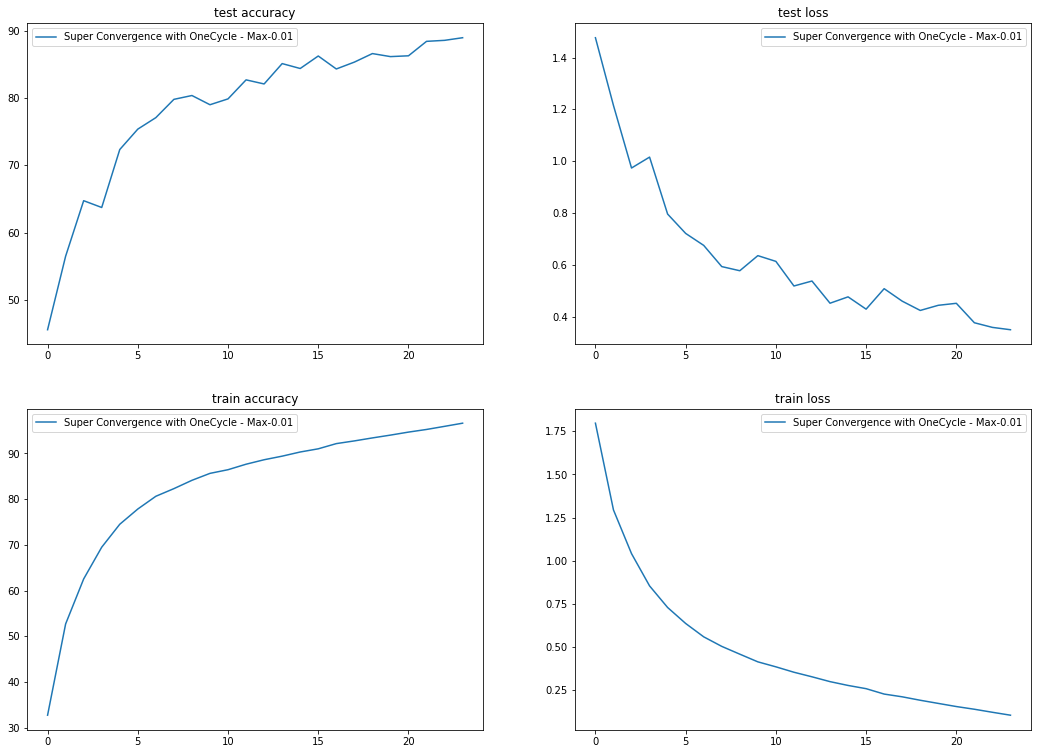

In [17]:
plot_experiments([exp6])